In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import shutil
import nibabel as nib
import pydicom as dicomio 
import torch
import torch.optim as optim
import time

# 让 matplotlib 图表直接在 Jupyter 中显示
%matplotlib inline 

# 导入本地模块
try:
    from loss import TverskyLoss, MixedLoss
    from net import UNet_2D, UNet_3D
    from volume_patch_composer import volume_composer, patch_creator
    from dataset import Pancreas_2D_dataset, Pancreas_3D_dataset, partitioning
    from metrics import performance_metrics
    from train import train_2D, train_3D
    from inference import get_inference_performance_metrics_3D
except ImportError as e:
    print(f"❌ 错误: 缺少必要的模块文件 (如 net.py, loss.py)。\n详细信息: {e}")

print("库导入完成。")

ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/albumentations/check_version.py", line 32, in fetch_version_info
    data = response.read()
  File "/usr/local/lib/python3.10/http/client.py", line 482, in read
    s = self._safe_read(self.length)
  File "/usr/local/lib/python3.10/http/client.py", line 631, in _safe_read
    data = self.fp.read(amt)
  File "/usr/local/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/local/lib/python3.10/ssl.py", line 1307, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/local/lib/python3.10/ssl.py", line 1163, in read
    return self._sslobj.read(len, buffer)
TimeoutError: The read operation timed out


库导入完成。


In [2]:
# ================= ⚙️ 配置区域 =================
CONFIG = {
    'raw_ct_dir': './Pancreas-CT',              
    'raw_label_dir': './Pancreas-CT-Label',     
    'processed_2d_dir': './data',               
    'processed_3d_dir': './data3D',             
    
    'unet_2d': False,              
    'batch_size': 32,                
    'num_workers': 4,               
    'n_epochs': 50,                
    'inference_only': False,       
    'train_on_gpu': torch.cuda.is_available(),
    'seed': 51
}

# ================= 🛠️ 工具函数 =================
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

def process_ct_window(ct_array, w_level=40, w_width=400):
    min_val = w_level - w_width / 2
    max_val = w_level + w_width / 2
    ct_clipped = np.clip(ct_array, min_val, max_val)
    ct_norm = (ct_clipped - min_val) / (max_val - min_val)
    ct_norm = ct_norm * 255.0
    return ct_norm.astype(np.uint8)

def prepare_directories():
    for p in [CONFIG['processed_2d_dir'], CONFIG['processed_3d_dir']]:
        if not os.path.exists(p):
            os.makedirs(p)

# 设置随机种子
set_seed(CONFIG['seed'])
print("配置已加载。")

配置已加载。


In [3]:
def preprocess_data_robust():
    """鲁棒的数据预处理函数"""
    print("--- 检查数据状态 ---")
    check_patient = os.path.join(CONFIG['processed_2d_dir'], 'Patient0082', 'CT')
    if os.path.exists(check_patient) and len(os.listdir(check_patient)) > 0:
        print("✅ 检测到本地已有预处理数据 (./data)，跳过 PNG 生成步骤。")
        return

    print("🔄 未找到完整数据，开始执行预处理 (这可能需要几分钟)...")
    prepare_directories()

    # 检查 pydicom 版本兼容性
    try:
        if not hasattr(dicomio, 'dcmread'):
            dicomio.dcmread = dicomio.read_file
    except:
        pass

    for i in range(1, 83):
        patient_id = '{:04d}'.format(i)
        
        # 路径准备
        nifti_filename = f"label{patient_id}.nii.gz"
        nifti_path = os.path.join(CONFIG['raw_label_dir'], nifti_filename)
        ct_folder_pattern = os.path.join(CONFIG['raw_ct_dir'], f"PANCREAS_{patient_id}", "**", "*.dcm")
        
        # 1. 检查源文件
        if not os.path.exists(nifti_path):
            # print(f"⚠️  [Patient {patient_id}] 跳过: 找不到标签文件")
            continue
        
        dcm_files = glob.glob(ct_folder_pattern, recursive=True)
        if not dcm_files:
            # print(f"⚠️  [Patient {patient_id}] 跳过: 找不到 DICOM 文件")
            continue

        # 2. 读取并排序 DICOM
        try:
            slices = []
            for f in dcm_files:
                try:
                    ds = dicomio.dcmread(f)

                    # 先转为 float 避免计算溢出
                    image = ds.pixel_array.astype(np.float32)
                    
                    # 应用斜率和截距 (如果存在)
                    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
                        slope = float(ds.RescaleSlope)
                        intercept = float(ds.RescaleIntercept)
                        image = image * slope + intercept

                    # slices.append(ds)
                    slices.append((float(ds.ImagePositionPatient[2]), image))
                except Exception:
                    pass
            
            if not slices:
                continue

            # 按 Z 轴位置排序
            # slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
            slices.sort(key=lambda x: x[0])
            
        except Exception as e:
            print(f"❌ [Patient {patient_id}] 处理崩溃: {e}")
            continue

        # 3. 读取 Mask
        try:
            mask_obj = nib.load(nifti_path)
            mask_data = mask_obj.get_fdata()
        except Exception as e:
            print(f"❌ [Patient {patient_id}] NIfTI 读取失败: {e}")
            continue

        # 4. 对齐层数
        num_dcm = len(slices)
        num_mask = mask_data.shape[2]
        valid_slices = min(num_dcm, num_mask)
        
        if valid_slices < 10:
            continue
            
        # 5. 保存 PNG
        save_dir_ct = os.path.join(CONFIG['processed_2d_dir'], 'Patient' + patient_id, 'CT')
        save_dir_mask = os.path.join(CONFIG['processed_2d_dir'], 'Patient' + patient_id, 'Masks')
        os.makedirs(save_dir_ct, exist_ok=True)
        os.makedirs(save_dir_mask, exist_ok=True)

        # ... (前面的代码保持不变)
        try:
            for s in range(valid_slices):
                mask_slice = mask_data[:, :, s]
                
                # 获取原始 CT 数据
                # raw_ct_slice = slices[s].pixel_array.transpose(1, 0)
                raw_ct_slice = slices[s][1].transpose(1, 0)
                
                # --- 🔥 修改开始 🔥 ---
                # 1. 对 CT 进行窗位调整和归一化 (关键修复!)
                processed_ct_slice = process_ct_window(raw_ct_slice, w_level=40, w_width=400)
                
                # 2. 确保 Mask 也是 uint8 格式 (0 和 255, 或者 0 和 1)
                # 建议将 Mask 乘以 255 以便肉眼观察，但在读取时要除回来
                mask_slice = (mask_slice * 255).astype(np.uint8)
                # 这里为了兼容你现有的 dataset 代码(假设它读取0/1)，我们保持 0/1 但转为 uint8
                # mask_slice = mask_slice.astype(np.uint8)
                # --- 🔥 修改结束 🔥 ---

                filename = f"{s:04d}.png"
                cv2.imwrite(os.path.join(save_dir_mask, filename), mask_slice)
                cv2.imwrite(os.path.join(save_dir_ct, filename), processed_ct_slice)
            
        except Exception as e:
            print(f"❌ [Patient {patient_id}] 保存出错: {e}")      

    print("--- 数据预处理完成 ---")

In [4]:
# 1. 执行预处理
preprocess_data_robust()

# 2. 构建数据索引
print("构建文件索引...")
patient_path_list = {'CT': {}, 'Masks': {}}
patient_image_cnt_CT = {}
patient_image_cnt_Mask = {}
valid_patients = []
patient_dirs = sorted(glob.glob(os.path.join(CONFIG['processed_2d_dir'], 'Patient*')))

for p_dir in patient_dirs:
    p_key = os.path.basename(p_dir)
    ct_files = sorted(glob.glob(os.path.join(p_dir, 'CT', '*.png')))
    mask_files = sorted(glob.glob(os.path.join(p_dir, 'Masks', '*.png')))
    if len(ct_files) > 0 and len(ct_files) == len(mask_files):
        patient_path_list['CT'][p_key] = ct_files
        patient_path_list['Masks'][p_key] = mask_files
        patient_image_cnt_CT[p_key] = len(ct_files)
        patient_image_cnt_Mask[p_key] = len(mask_files)
        valid_patients.append(p_key)

print(f"有效病例数: {len(valid_patients)}")

# 3. 3D 数据缓存
print("检查 3D 数据缓存...")
d1 = torch.linspace(-1, 1, 256)
d2 = torch.linspace(-1, 1, 256)
d3 = torch.linspace(-1, 1, 128)
meshx, meshy, meshz = torch.meshgrid((d1, d2, d3), indexing='ij')
grid = torch.stack((meshx, meshy, meshz), 3).unsqueeze(0)

new_pt_count = 0
for patient in valid_patients:
    out_ct_path = os.path.join(CONFIG['processed_3d_dir'], patient + '_CT.pt')
    if not os.path.exists(out_ct_path):
        try:
            volume_composer(patient, patient_image_cnt_CT, patient_path_list, grid)
            new_pt_count += 1
        except Exception as e:
            print(f"Resizing {patient} error: {e}")

if new_pt_count == 0:
    print("✅ 所有 3D 数据 (.pt) 已存在，跳过重采样步骤。")
else:
    print(f"🔄 新生成了 {new_pt_count} 个 3D 数据文件。")

--- 检查数据状态 ---
✅ 检测到本地已有预处理数据 (./data)，跳过 PNG 生成步骤。
构建文件索引...
有效病例数: 80
检查 3D 数据缓存...
✅ 所有 3D 数据 (.pt) 已存在，跳过重采样步骤。


In [5]:
# 4. 训练准备
print("准备 Dataset...")
part = partitioning(valid_patients, split_ratio=[0.7, 0.1, 0.2])

kc, kh, kw = 32, 64, 64
dc, dh, dw = 32, 64, 64

CT_patches = {}
mask_patches = {}

print("加载 Patches (这步需要一点内存)...")
for p in ['train', 'valid']:
    CT_patches[p], mask_patches[p] = patch_creator(part[p], kw, kh, kc, dw, dh, dc)

dataset_train = Pancreas_3D_dataset(CT_patches['train'], mask_patches['train'], augment=True, is_train=True)
dataset_valid = Pancreas_3D_dataset(CT_patches['valid'], mask_patches['valid'], augment=False, is_train=False)

loaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=CONFIG['batch_size'], 
                                         shuffle=True, num_workers=CONFIG['num_workers']),
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=CONFIG['batch_size'], 
                                         shuffle=False, num_workers=CONFIG['num_workers'])
}
print("DataLoader 准备就绪。")

准备 Dataset...
train:  56   valid:  7   test:  17   total:  80
加载 Patches (这步需要一点内存)...
Filtering patches... Original size: 3584
Filtered size: 3584
DataLoader 准备就绪。


In [6]:
# 5. 初始化模型与优化器
print("初始化模型...")
model = UNet_3D(1, 1, 32, 0.2)
if CONFIG['train_on_gpu']:
    model.cuda()        

# ================= 关键修改：加载预训练模型 =================
# ⚠️ 注意：请确认文件名是否正确
checkpoint_path = './results/run_20251126-_model.pt' 

if os.path.exists(checkpoint_path):
    print(f"🔄 正在加载预训练模型: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path))
    print("✅ 加载成功！将在现有基础上继续训练。")
else:
    print("⚠️ 未找到预训练模型，将从头开始训练。")     
# ========================================================

# ✅ 使用新的混合 Loss
# alpha=0.7 强调召回，bce_weight=0.5 提供梯度平滑
# criterion = MixedLoss(alpha=0.7, beta=0.3, bce_weight=0.1)

# 定义 Loss (这里用了你新的参数)
criterion = TverskyLoss(1e-6, 0.7, 0.3)
# 1. 定义基础优化器 (LR 会被 Scheduler 覆盖，所以这里初始 LR 可以随意，但建议设为 max_lr 的 1/10 或 1/25)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 2.定义 OneCycleLR
# max_lr: 最大学习率，可以尝试 1e-3 或 5e-4
# steps_per_epoch: 每个 epoch 的 batch 数量
# epochs: 总 epoch 数
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1e-3, 
    steps_per_epoch=len(loaders['train']), 
    epochs=CONFIG['n_epochs']
)

print("模型初始化完成。")

初始化模型...
⚠️ 未找到预训练模型，将从头开始训练。
模型初始化完成。


In [7]:
# 设置保存路径
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
timestamp = time.strftime("%Y%m%d-%H%M")
experiment_name = f"run_{timestamp}"
model_save_path = os.path.join(results_dir, f"{experiment_name}_model.pt")
loss_plot_path = os.path.join(results_dir, f"{experiment_name}_loss_curve.png")
metric_save_path = os.path.join(results_dir, f"{experiment_name}_metrics.csv")
result_save_path = os.path.join(results_dir, f"{experiment_name}_inference_results.csv")

print(f"🚀 开始训练: {experiment_name}")

if not CONFIG['inference_only']:
    # 3. 把 scheduler 传进去
    model = train_3D(CONFIG['n_epochs'], loaders, model, optimizer, criterion, 
                     CONFIG['train_on_gpu'], performance_metrics, model_save_path, 0.5, 
                     scheduler=scheduler) # 传入 scheduler
    
    # 训练结束后处理数据
    if os.path.exists('performance_metrics.csv'):
        df = pd.read_csv('performance_metrics.csv')
        df.to_csv(metric_save_path, index=False)
        
        # 直接在 Jupyter 中画图
        plt.figure(figsize=(10, 5))
        plt.plot(df['epoch'], df['Training Loss'], label='Train')
        plt.plot(df['epoch'], df['Validation Loss'], label='Valid')
        plt.legend()
        plt.title(f'Training Process ({experiment_name})')
        plt.show() # 直接显示
        
        plt.savefig(loss_plot_path)
        print("训练完成。")

🚀 开始训练: run_20251129-0512


  0%|          | 0/51 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 32, 64, 64])
DEBUG: Target Shape: torch.Size([32, 1, 32, 64, 64])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 112...
51 / 112...
101 / 112...
=== Validation ===
1 / 14...
Epoch: 1 	Training Loss: 0.9927 	Validation Loss: 0.9866
Specificity: 0.691167 	Sensitivity: 0.928364 	F2_score: 0.028947 	DSC: 0.011858
Validation DSC increased.  Saving model ...


  2%|▏         | 1/51 [03:03<2:32:39, 183.18s/it]

=== Epoch #2 ===
=== Training ===

DEBUG: Data Shape: torch.Size([32, 1, 32, 64, 64])
DEBUG: Target Shape: torch.Size([32, 1, 32, 64, 64])

DEBUG: Target Max Value: 1
✅ Mask 值正常 (0-1)。
1 / 112...


  2%|▏         | 1/51 [03:10<2:39:08, 190.96s/it]


KeyboardInterrupt: 

In [ ]:
print("\n--- 开始测试集评估 ---")
# 加载刚刚训练好的模型（或者你可以手动指定其他路径）
best_model_path = model_save_path 

if os.path.exists(best_model_path):
    print(f"加载模型权重: {best_model_path}...")
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    
    print(f"正在测试 {len(part['test'])} 个测试集病例...")
    df_test = get_inference_performance_metrics_3D(model, part['test'], Pancreas_3D_dataset, 
                                                  CONFIG['batch_size'], CONFIG['train_on_gpu'], 
                                                  0.5, kw, kh, kc, dw, dh, dc)
    print("\n📊 测试集结果统计:")
    display(df_test.describe()) # Jupyter 特有的漂亮表格显示
    
    df_test.to_csv(result_save_path, index=False)
    print(f"✅ 详细测试结果已保存至: {result_save_path}")
else:
    print("未找到模型文件。")

🚀 正在处理病人: Patient0017 ...
✅ 找到真值(Ground Truth)！
📍 胰腺分布在第 50 层 到 第 82 层 (共 33 层)。
🎯 正在展示包含胰腺面积最大的 4 个切片: [53, 54, 55, 56]


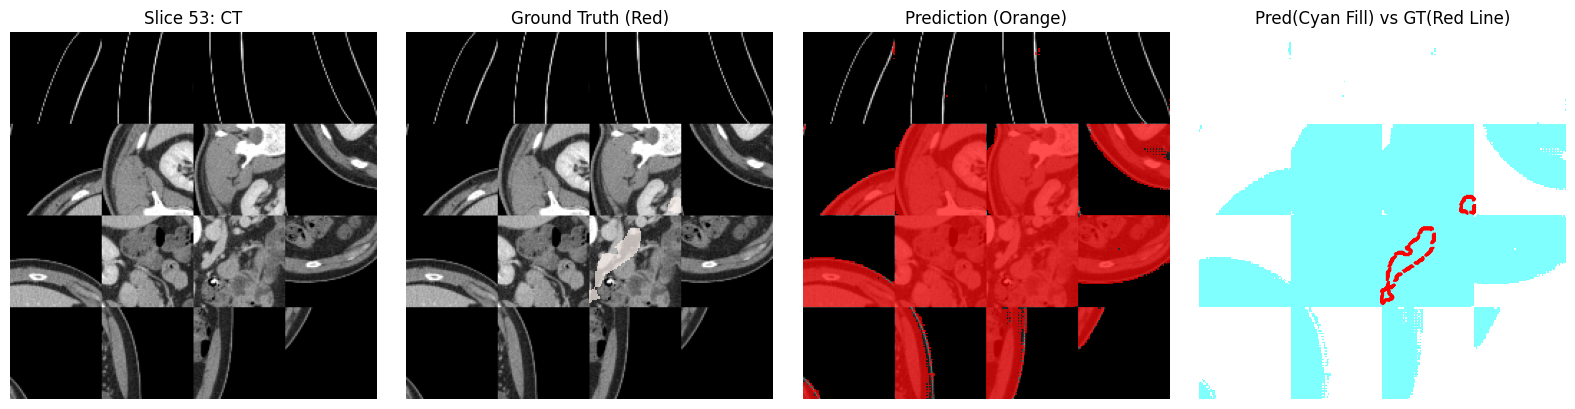

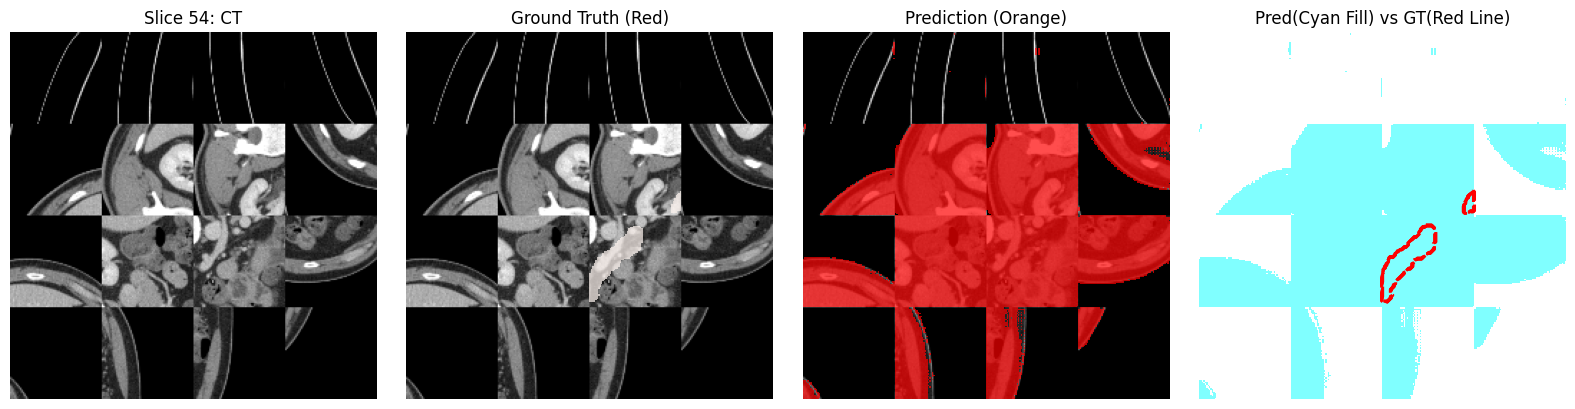

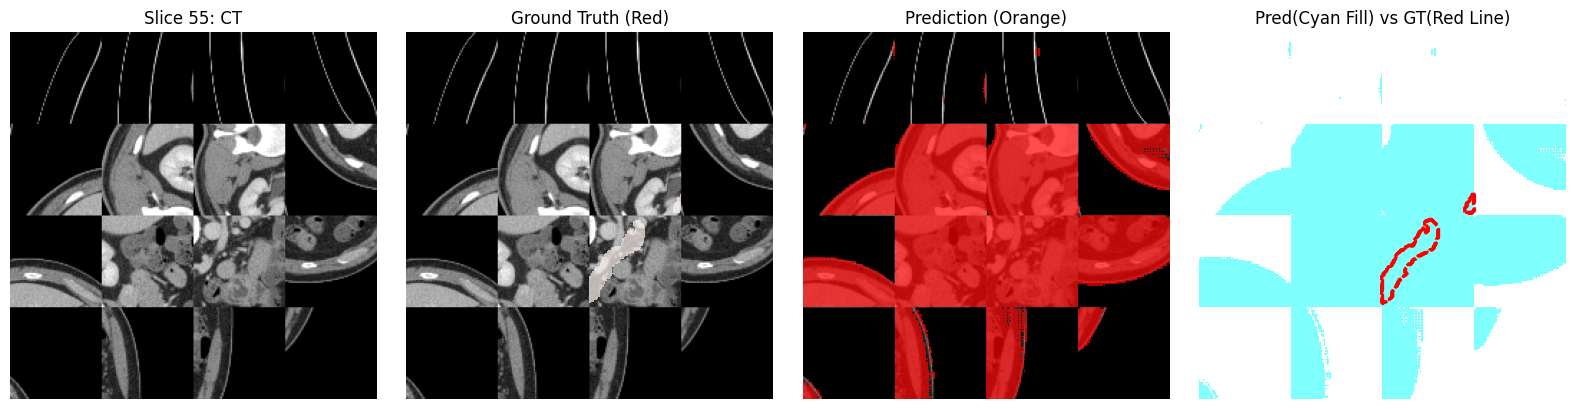

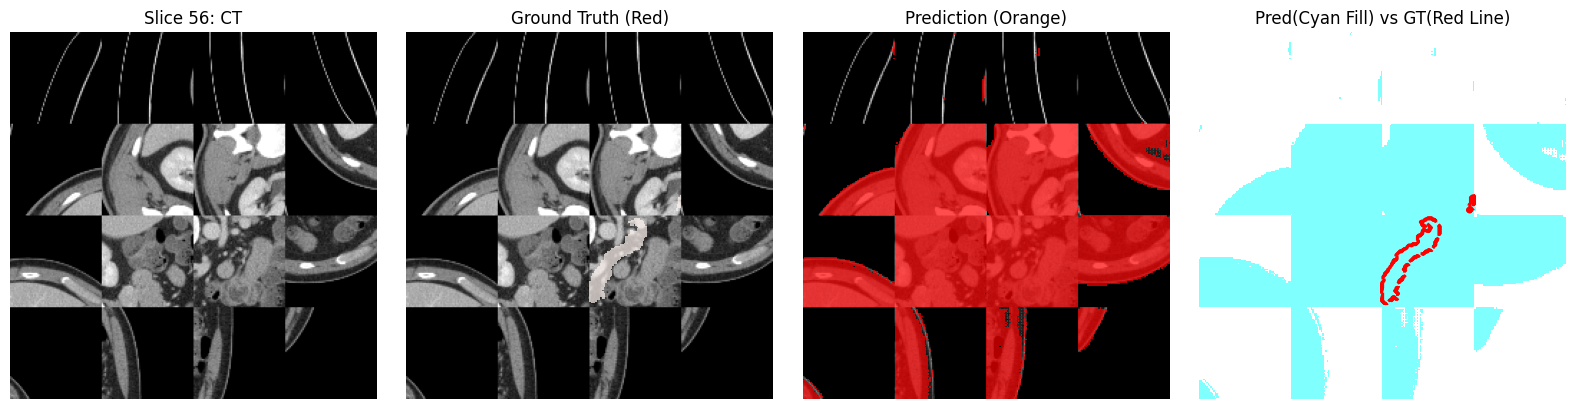

In [8]:
from inference import visualize_patient_prediction_3D

visualize_smart_check(
    model=model, 
    patient='Patient0017', # 或者是 target_patient
    Pancreas_3D_dataset=Pancreas_3D_dataset, 
    batch_size=4, 
    train_on_gpu=CONFIG['train_on_gpu'],
    threshold=0.5, 
    kw=kw, kh=kh, kc=kc, dw=dw, dh=dh, dc=dc
)